## Chest X-ray Image Classification: Pneumonia vs. Normal

### Analyzing and Classifying Chest X-ray Images using Deep Learning Techniques

In this notebook, we will explore and analyze a dataset containing chest X-ray images of pediatric patients. The goal is to develop a deep learning model to accurately classify the images into two categories: Pneumonia and Normal. We will utilize popular libraries such as numpy, pandas, matplotlib, seaborn, and torch for data manipulation, visualization, and building the neural network model. Additionally, scikit-learn will be used for evaluating the model's performance through metrics like classification report and confusion matrix. The process will include preprocessing the images, splitting the dataset into training and testing sets, training the model, and evaluating its performance. Finally, we will discuss the results and insights gained from the analysis.


# Importing Libraries and Modules

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm
import os

import torch
import torchvision
import torchvision.transforms as transforms

import torch.utils.data as data
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from  torchvision.models import efficientnet_v2_s,EfficientNet_V2_S_Weights,vgg19
# from tensorflow.python.keras.utils.np_utils import to_categorical
import torch.nn.functional as F


In [38]:
## Destination Path for Chest X-ray Images

dest_path = "Chest_X_Ray_Images_(Pneumonia)_project/"

### Extracting Chest X-ray Images from ZIP Archive


In [39]:

# # Specify the path to the ZIP file
# zip_path = "Chest X-Ray Images (Pneumonia).zip"

# # Extract the ZIP file with progress bar
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     # Get the total number of files in the ZIP archive
#     total_files = len(zip_ref.namelist())

#     # Extract files with tqdm progress bar
#     with tqdm(total=total_files, desc="Extracting ZIP") as pbar:
#         for file in zip_ref.namelist():
#             zip_ref.extract(file, dest_path)
#             pbar.update(1)

## Dataset Exploration: Counting Images in Categories

This code block defines the `explore_dataset` function, which calculates and returns the number of images in different categories (normal and pneumonia) within the train, test, and validation sets. It helps provide a quick overview of the dataset's distribution.


In [40]:
def explore_dataset(dataset_dir):
    # Get the paths to the train, test, and validation directories
    train_dir = os.path.join(dataset_dir, "train")
    test_dir = os.path.join(dataset_dir, "test")
    val_dir = os.path.join(dataset_dir, "val")

    # Count the number of images in each category (normal and pneumonia) in the train set
    train_normal_images = os.listdir(os.path.join(train_dir, "NORMAL"))
    train_pneumonia_images = os.listdir(os.path.join(train_dir, "PNEUMONIA"))

    num_train_normal = len(train_normal_images)
    num_train_pneumonia = len(train_pneumonia_images)

    # Count the number of images in each category (normal and pneumonia) in the test set
    test_normal_images = os.listdir(os.path.join(test_dir, "NORMAL"))
    test_pneumonia_images = os.listdir(os.path.join(test_dir, "PNEUMONIA"))

    num_test_normal = len(test_normal_images)
    num_test_pneumonia = len(test_pneumonia_images)

    # Count the number of images in each category (normal and pneumonia) in the validation set
    val_normal_images = os.listdir(os.path.join(val_dir, "NORMAL"))
    val_pneumonia_images = os.listdir(os.path.join(val_dir, "PNEUMONIA"))

    num_val_normal = len(val_normal_images)
    num_val_pneumonia = len(val_pneumonia_images)

    return (num_train_normal, num_train_pneumonia,
            num_test_normal, num_test_pneumonia,
            num_val_normal, num_val_pneumonia)

## Class Distribution Visualization: Training, Validation, and Test Sets

This code block defines the `visualize_class_distribution` function, which plots bar charts to visualize the distribution of classes (normal and pneumonia) in the training, validation, and test sets. It provides insights into the class distribution across different datasets.

In [41]:
def visualize_class_distribution(class_labels, train_counts, test_counts, val_counts):
    datasets = ['Training Set', 'Validation Set', 'Test Set']
    counts = [train_counts, val_counts, test_counts]

    plt.figure(figsize=(16, 6))

    for i in range(len(datasets)):
        plt.subplot(1, 3, i+1)
        sns.barplot(x=class_labels, y=counts[i])
        plt.title(f"Distribution of Classes in {datasets[i]}")
        plt.xlabel("Class")
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

## Dataset Exploration, Class Distribution, and Sample Images

This code block explores the dataset, visualizes the class distribution, and displays sample images. It provides a quick overview of the dataset's characteristics and showcases sample images from different classes.

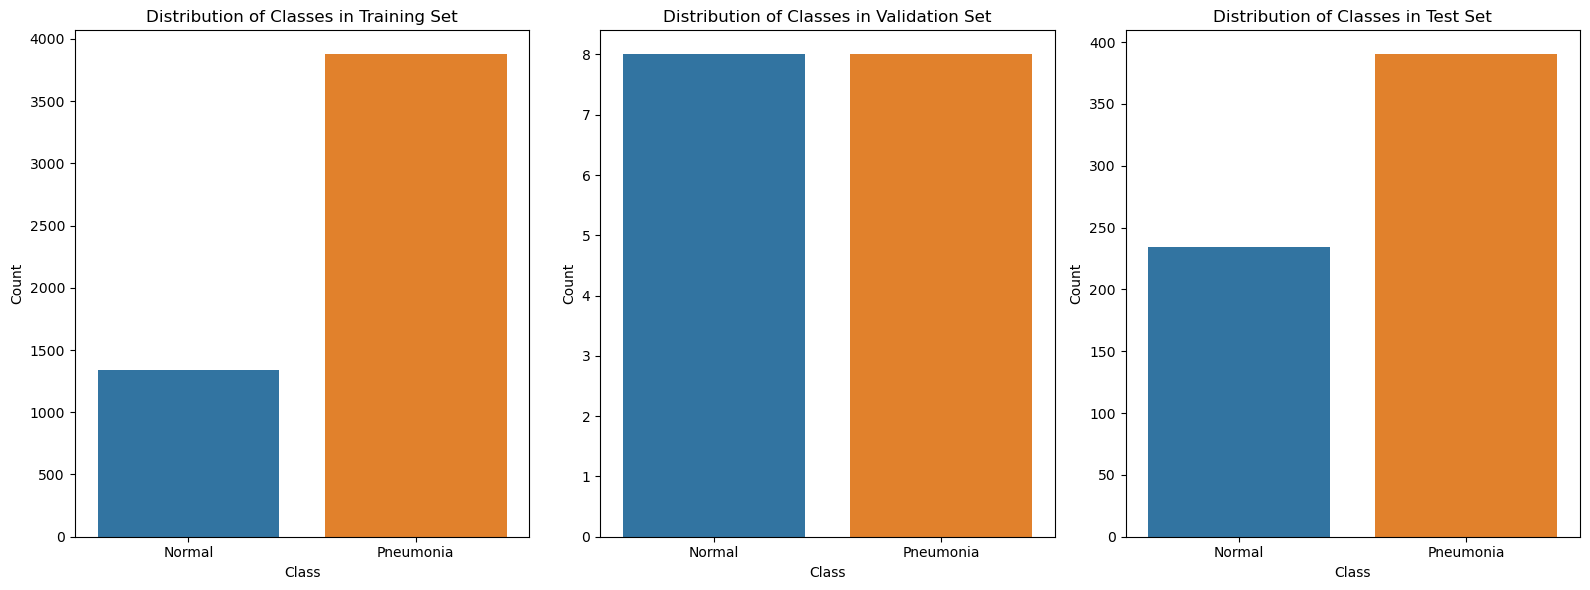

In [42]:
dataset_dir = dest_path+"chest_xray"

# Explore the dataset
num_train_normal, num_train_pneumonia, num_test_normal, num_test_pneumonia, num_val_normal, num_val_pneumonia = explore_dataset(dataset_dir)

# Define class labels and counts
class_labels = ["Normal", "Pneumonia"]
train_counts = [num_train_normal, num_train_pneumonia]
test_counts = [num_test_normal, num_test_pneumonia]
val_counts = [num_val_normal, num_val_pneumonia]

# Visualize class distribution
visualize_class_distribution(class_labels, train_counts, test_counts, val_counts)

# Display sample images
train_normal_samples = [os.path.join(dataset_dir, "train/NORMAL", image) for image in os.listdir(os.path.join(dataset_dir, "train/NORMAL"))[:3]]
train_pneumonia_samples = [os.path.join(dataset_dir, "train/PNEUMONIA", image) for image in os.listdir(os.path.join(dataset_dir, "train/PNEUMONIA"))[:3]]

## Displaying Sample Images from Image Paths

This code block defines the `display_sample_images` function, which takes a list of image paths as input and displays the corresponding images. It provides a quick way to visualize and verify the sample images from the dataset.

In [43]:
def display_sample_images(image_paths):
    plt.figure(figsize=(12, 6))
    num_samples = len(image_paths)
    for i,image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = image_path.split("/")[-1].split("\\")[0]
        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(img)
        plt.title(str(label).upper())
        plt.axis("off")

    plt.show()

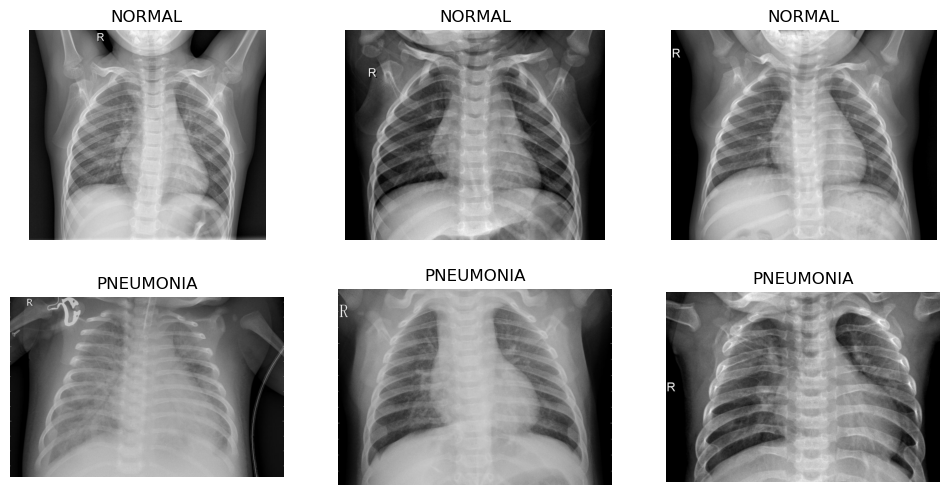

In [44]:
display_sample_images(train_normal_samples + train_pneumonia_samples)

In [45]:
## check if CUDA is available
torch.cuda.is_available()

True

In [12]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((100, 100)),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale has only one channel
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize((100, 100)),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229])
#     ])
# }


## Dataset Loading and Transformation

This code block loads the dataset using the `ImageFolder` class from torchvision.datasets. It applies different transformations to the images based on the dataset split (train, val, test). The batch size for data loading is also defined.


In [47]:
data_dir = "Chest_X_Ray_Images_(Pneumonia)_project/chest_xray/chest_xray"
batch_size = 64

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(25),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale has only one channel
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}


# Load the datasets with ImageFolder
image_datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(data_dir, x),
                                                      transform=data_transforms[x])
                  for x in ['train', 'val','test']}

## Augmented Image Generation

This code block defines the `generate_augmented_images` function, which generates augmented images from a given dataset. The function applies additional augmentations to the original image, creating multiple augmented versions.

The augmented images are generated using the `yield` keyword, which allows for the creation of generators that produce augmented image-label pairs.

Using this function, generators for the augmented training, validation, and test datasets are created with different numbers of augmentations.


In [48]:
def generate_augmented_images(dataset, num_augmentations):
    for image, label in dataset:
        yield image, label

        # Apply additional augmentations to the original image
        for _ in range(num_augmentations):
            augmented_image = transforms.Compose([
                # Apply your desired augmentations here
                transforms.Resize((100, 100)),
                transforms.RandomCrop((90, 90)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=(-10, 10)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229])
            ])(image)
            yield augmented_image, label

# Create generators for the augmented datasets
augmented_train_generator = generate_augmented_images(image_datasets["train"], 10)
augmented_val_generator = generate_augmented_images(image_datasets["val"], 50)
augmented_test_generator = generate_augmented_images(image_datasets["test"], 1)


In [ ]:
# Create new DataLoaders using the generators
# augmented_train_loader = torch.utils.data.DataLoader(augmented_train_generator, batch_size=batch_size, shuffle=True)
# augmented_val_loader = torch.utils.data.DataLoader(augmented_val_generator, batch_size=batch_size, shuffle=True)
# augmented_test_loader = torch.utils.data.DataLoader(augmented_test_generator, batch_size=batch_size, shuffle=False)

In [99]:
# augmented_loaders = {}
# augmented_dataset = []

# # Iterate over the original validation dataset
# for train_val_test in image_datasets:
#     for image, label in tqdm(image_datasets[train_val_test]):
#         augmented_images = []
#         # Apply the original transformations to the image
#         original_transformed = image
#         augmented_images.append(original_transformed)

#         # Apply additional augmentations to the original image
#         for _ in range(50):
#             augmented_image = data_transforms[train_val_test](transforms.ToPILImage()(image))
#             augmented_images.append(augmented_image)

#         augmented_dataset.extend(augmented_images)

#     # Create a new DataLoader for the augmented validation dataset
#     augmented_loaders[train_val_test] = torch.utils.data.DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

 30%|███████████████████████▋                                                      | 1580/5216 [05:34<12:48,  4.73it/s]


KeyboardInterrupt: 

In [60]:

# Data loading
data_dir = "Chest_X_Ray_Images_(Pneumonia)_project/chest_xray/chest_xray"
batch_size = 64

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(25),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale has only one channel
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}





# Load the datasets with ImageFolder
image_datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(data_dir, x),
                                                      transform=data_transforms[x])
                  for x in ['train', 'val','test']}

# Create data loaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val', 'test']}


## Pretrained VGG19 Model Loading

This code block loads the VGG19 model pretrained on the ImageNet dataset. The pretrained model is downloaded and initialized with the weights learned from the ImageNet dataset.

In [ ]:
# Load the pretrained VGG19 model
model = vgg19(pretrained=True)

## Model Definition and Modification

This code block defines the model architecture and modifies it to fit the number of classes in the dataset. The pretrained VGG19 model is loaded and the last fully connected layer is replaced with a new linear layer that matches the number of classes. The model is then moved to the appropriate device for training.

In [ ]:
# Define the model
model = models.vgg19(pretrained=True)
num_classes = len(image_datasets['train'].classes)
num_features = model.classifier[6].in_features

# Modify the model to accept grayscale input
# model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(num_features, num_classes)

# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Criterion, Optimizer, and Training Configuration

This code block sets up the loss criterion, optimizer, number of epochs, and device for training the model. The criterion is the binary cross-entropy loss, the optimizer is stochastic gradient descent with specified parameters, and the device is configured based on GPU availability.

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 30
device

## Model Training and Evaluation

This code block trains the model for the specified number of epochs. For each epoch, the model is trained on the augmented training data and the loss is computed. After each epoch, the model is evaluated on the augmented validation data to calculate the accuracy. The progress and results are printed for each epoch.



In [ ]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(augmented_loaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        predicted_probabilities = torch.sigmoid(outputs)
        labels = F.one_hot(labels, num_classes=2).float()
        labels = labels.to(device)
        loss = criterion(predicted_probabilities, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(augmented_loaders['train'])
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(augmented_loaders['val']):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the val set: {accuracy:.2f}%")
    

## Model Evaluation on Test Set

This code block evaluates the trained model on the augmented test set. The model is switched to evaluation mode using `model.eval()`. Then, the model makes predictions on the test set and compares them with the true labels to calculate the accuracy. The accuracy is printed as a percentage.



In [ ]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in tqdm(augmented_loaders['test']):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = 100.0 * correct_predictions / total_predictions
print(f"Accuracy on the test set: {accuracy:.2f}%")

In [ ]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        predicted_probabilities = torch.sigmoid(outputs)
        labels = F.one_hot(labels, num_classes=2).float()
        labels = labels.to(device)
        loss = criterion(predicted_probabilities, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(image_datasets['train'])
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloaders['val']):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the val set: {accuracy:.2f}%")
    
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloaders['test']):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the test set: {accuracy:.2f}%")
